In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import random
from sklearn.cross_validation import cross_val_score # K折交叉验证模块
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import Normalizer
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.multiclass import OutputCodeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.pipeline import Pipeline as ImPineline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.grid_search import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

import time
%matplotlib inline

/Users/cql/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/cql/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def submit(fileName, testTotal, preds):
    submission = testTotal[['id']]
    submission['pred'] = preds
    submission.to_csv('./predicts/'+fileName, header=False, index=False)
    return submission
    

In [4]:
def extractFeature(train_feature, partition=2, randomPartion=False, prefix="p", onlyAvg=False, filterLow=False, levelFeature=False, scaleSpec=True, smooth=False, extract=True):
    if extract==False:
        return train_feature
    if scaleSpec:
        train_feature = pd.DataFrame(scale(train_feature, axis=1))
    if smooth:
        train_feature = train_feature.rolling(100, axis=1).mean()
    if filterLow:
        train_feature[train_feature<1] = 0
    plen = train_feature.shape[1]/partition
    features = pd.DataFrame()
    avgs = pd.DataFrame()
    for i in range(0, partition):
        pstart = random.randint(0, train_feature.shape[1]-plen-1)
        pendExclue = pstart + plen + 1
        avgC = train_feature.iloc[:, pstart:pendExclue].mean(axis=1)
        stdC = train_feature.iloc[:, pstart:pendExclue].std(axis=1)
        maxC = train_feature.iloc[:, pstart:pendExclue].max(axis=1)
        minC = train_feature.iloc[:, pstart:pendExclue].min(axis=1)
        medianC = train_feature.iloc[:, pstart:pendExclue].median(axis=1)
        diffC = train_feature.iloc[:, pstart:pendExclue].diff(axis=1).iloc[:,1:]
        features[prefix+'_avg'+str(i)] = avgC
        avgs[prefix+'_avg'+str(i)] = avgC
        if onlyAvg==False:
            features[prefix+'_std'+str(i)] = stdC
            features[prefix+'_median'+str(i)] = medianC
            features[prefix+'_max'+str(i)] = maxC
            features[prefix+'_min'+str(i)] = minC
            features[prefix+'_avg_m_std'+str(i)] = stdC/avgC
            features[prefix+'_max_m_avg'+str(i)] = maxC/avgC
            features[prefix+'_min_m_avg'+str(i)] = minC/avgC
#             features[prefix+'_media_m_avg'+str(i)] = medianC/avgC
    if levelFeature:
        level_feature = extractFeature(avgs, prefix="l", partition = 4)
        features = pd.concat([features, level_feature], axis = 1)
    return features.fillna(0)

In [56]:
def readTotalFeature(fileName, maxFileIndex, hasLabel=True, partition = 20, extract=True):
    total_train_feature = pd.DataFrame()
    for i in range(0, maxFileIndex+1):
        print('processing:' + str(i))
        train_set = pd.read_csv(fileName + str(i) +'.csv', header=None)
        renameCol = {0:'id'}
        if hasLabel:
            renameCol[train_set.shape[1]-1] = 'label'
        train_set.rename(columns=renameCol, inplace=True)
        if hasLabel:
            processed_train = extractFeature(train_set.iloc[:,1:-1],partition, levelFeature=False, smooth=False, extract=extract)
            processed_train['id'] = train_set.id
            processed_train['label'] = train_set.label
        else:
            processed_train = extractFeature(train_set.iloc[:,1:],partition, levelFeature=False, smooth=False, extract=extract)
            processed_train['id'] = train_set.id
        total_train_feature = total_train_feature.append(processed_train, ignore_index=True)
    return total_train_feature.sample(total_train_feature.shape[0], replace=False)

In [98]:
total_train_feature.head()

,1,2,3,4,5,6,7,8,9,10,...,2593,2594,2595,2596,2597,2598,2599,2600,id,label
51396,3720.575814,4294.383061,4922.529006,5529.650667,5655.564531,5932.326219,6043.298327,5744.498338,5599.248442,5856.873989,...,608.841323,592.043072,575.692858,563.452547,556.987406,569.254092,585.354461,587.734560,825800,star
9685,181.862612,299.150734,260.790374,279.503279,282.766934,219.456038,204.036171,227.823392,197.425822,177.358902,...,116.019613,118.559039,112.349723,99.133837,89.005506,91.392144,106.544880,119.630625,1134959,star
13457,522.270044,530.708947,734.625823,623.498544,665.511496,564.624696,685.684121,561.556215,373.016989,388.986783,...,2012.444317,2015.365400,2025.687573,1935.334211,1933.055401,1950.665295,1958.266393,2019.340211,1079780,star
49413,0.818920,53.958010,35.525718,43.655621,58.104487,36.545800,30.269947,39.730626,27.549043,23.655744,...,152.168352,150.999216,148.228218,144.051001,138.767619,140.460807,148.934777,155.686051,1231718,star
58814,719.676165,836.076455,964.277328,990.853884,862.052128,898.067314,863.141174,655.433342,475.223836,448.332599,...,3854.309133,3802.123085,3539.188100,3329.812729,3389.503390,3576.131267,3796.923605,3918.850373,989852,star


In [57]:
validMode = True
reFeature = True
rng = np.random.RandomState(42)

In [58]:
if reFeature:
    total_train_feature = readTotalFeature('./train_feature_all_', 5, partition=20)
    total_train_feature.to_csv('./train_feature_check_point.csv', index=False)
else :
    total_train_feature = pd.read_csv('./train_feature_check_point.csv')

processing:0
processing:1
processing:2
processing:3
processing:4
processing:5


In [64]:
def readSpec(specId, path):
    return pd.read_csv(path+'/'+str(specId)+'.txt')

In [ ]:
readSpec

In [59]:
display(total_train_feature.head())
total_train_feature.shape

,1,2,3,4,5,6,7,8,9,10,...,2593,2594,2595,2596,2597,2598,2599,2600,id,label
51396,3720.575814,4294.383061,4922.529006,5529.650667,5655.564531,5932.326219,6043.298327,5744.498338,5599.248442,5856.873989,...,608.841323,592.043072,575.692858,563.452547,556.987406,569.254092,585.354461,587.734560,825800,star
9685,181.862612,299.150734,260.790374,279.503279,282.766934,219.456038,204.036171,227.823392,197.425822,177.358902,...,116.019613,118.559039,112.349723,99.133837,89.005506,91.392144,106.544880,119.630625,1134959,star
13457,522.270044,530.708947,734.625823,623.498544,665.511496,564.624696,685.684121,561.556215,373.016989,388.986783,...,2012.444317,2015.365400,2025.687573,1935.334211,1933.055401,1950.665295,1958.266393,2019.340211,1079780,star
49413,0.818920,53.958010,35.525718,43.655621,58.104487,36.545800,30.269947,39.730626,27.549043,23.655744,...,152.168352,150.999216,148.228218,144.051001,138.767619,140.460807,148.934777,155.686051,1231718,star
58814,719.676165,836.076455,964.277328,990.853884,862.052128,898.067314,863.141174,655.433342,475.223836,448.332599,...,3854.309133,3802.123085,3539.188100,3329.812729,3389.503390,3576.131267,3796.923605,3918.850373,989852,star


(60000, 2602)

In [60]:
X = total_train_feature.iloc[:,:-2]
Y = total_train_feature.iloc[:,-1]

# Split the dataset in two equal parts
x, t_x, y, t_y = train_test_split(
    X, Y, test_size=0.3, random_state=0)
x.shape


(42000, 2600)

In [61]:
def outlier_rejection(X, y):
    model = IsolationForest(n_jobs=-1, random_state=rng)
    model.fit(X)
    y_pred = model.predict(X)
    return X[y_pred == 1], y[y_pred == 1]

In [62]:
smote = SMOTE()
anova_filter = SelectKBest(f_classif, k=(int)(x.shape[1]*0.3))
model = RandomForestClassifier(n_jobs=4, class_weight='balanced', max_depth=70,  verbose=1,random_state=rng)
# model = AdaBoostClassifier(random_state=rng)
# model = GradientBoostingClassifier(random_state=rng,verbose=1)
# model = XGBClassifier()
# model = KNeighborsClassifier(n_neighbors = 3, n_jobs=-1)
scaler = StandardScaler()
clf = ImPineline([
#     ('anova', anova_filter),
#     ('scaler',scaler),
    ('smote',smote),
    ('model', model)
])


In [63]:
if validMode:
    rs = clf.fit(x, y)
    preds_test = clf.predict(t_x)
    clf.score(t_x, t_y)
    print("%0.3f" % f1_score(t_y, preds_test, average='macro'))  
    print(classification_report(t_y, preds_test, labels=['galaxy', 'qso', 'star', 'unknown']))
    print(confusion_matrix(t_y, preds_test, labels=['galaxy', 'qso', 'star', 'unknown']))

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   59.2s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


0.543
             precision    recall  f1-score   support

     galaxy       0.56      0.46      0.51       188
        qso       0.17      0.07      0.10        55
       star       0.98      0.95      0.96     16445
    unknown       0.51      0.71      0.60      1312

avg / total       0.94      0.92      0.93     18000

[[   87     2    34    65]
 [    0     4    10    41]
 [   42    11 15613   779]
 [   25     7   342   938]]


In [77]:
def plotSpec(tp, start=0, end=-1):
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    flen = 8
    for i in range(1,flen+1):
        plt.subplot(flen*100+10+i)
        plt.plot(tp.iloc[random.randint(0,tp.shape[0]-1),start:end] )
# plt.plot(star.iloc[random.randint(0,star.shape[0]),:] )
# plt.plot(star.iloc[random.randint(0,star.shape[0]),:] )

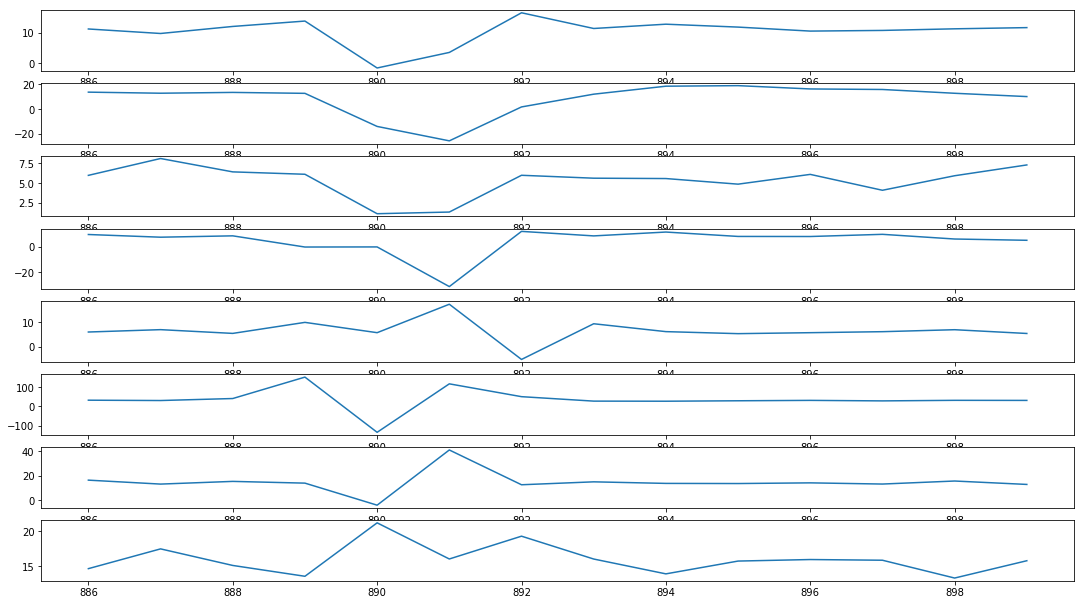

In [102]:
missed = t_x[t_y!=preds_test]
missed_feature = total_train_feature.loc[missed.index.values]
missed_feature.head()
missed_qso = missed_feature[missed_feature.label=='qso']
plotSpec(missed_qso.iloc[:,885:900])

/Users/cql/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


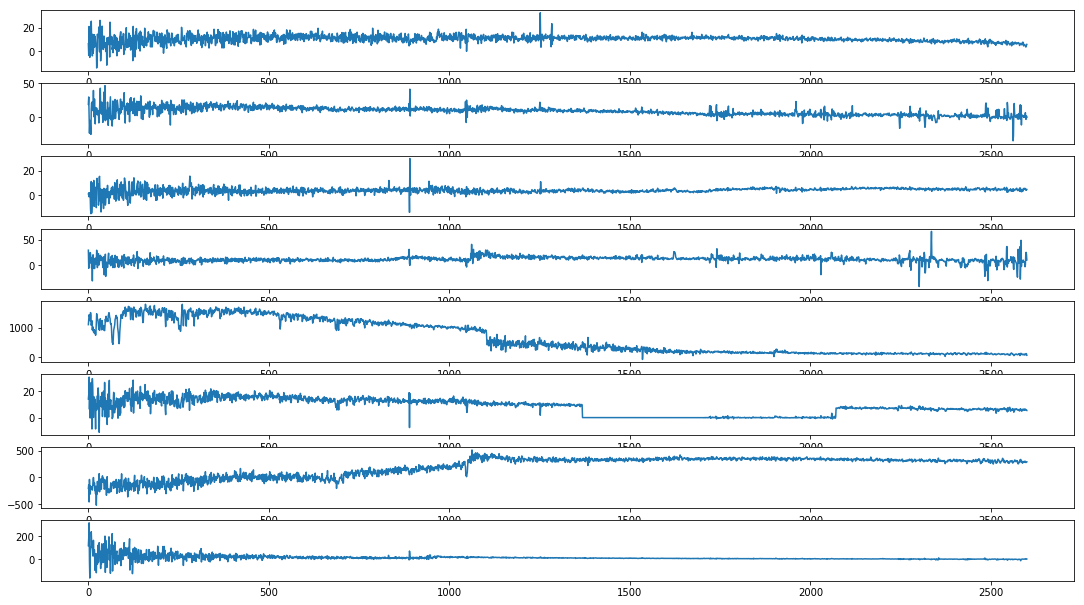

In [96]:
missed = t_x[t_y!=preds_test]
missed_feature = total_train_feature.loc[missed.index.values]
missed_feature.head()
missed_qso = missed_feature[total_train_feature.label=='star']
plotSpec(missed_qso.iloc[:,:-2])

/Users/cql/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


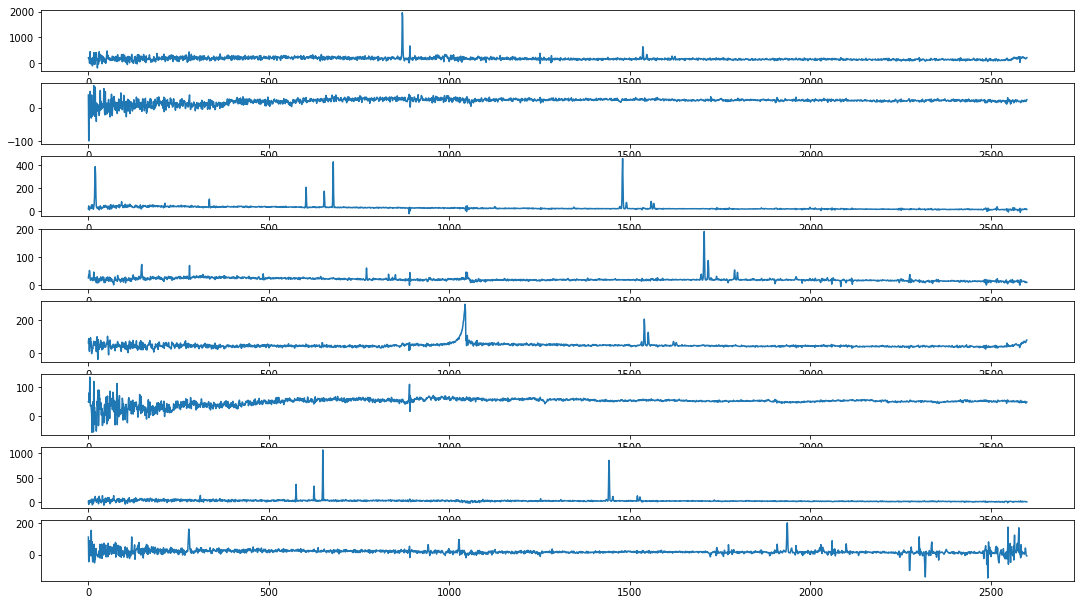

In [97]:
missed = t_x[t_y!=preds_test]
missed_feature = total_train_feature.loc[missed.index.values]
missed_feature.head()
missed_qso = missed_feature[total_train_feature.label=='galaxy']
plotSpec(missed_qso.iloc[:,:-2])

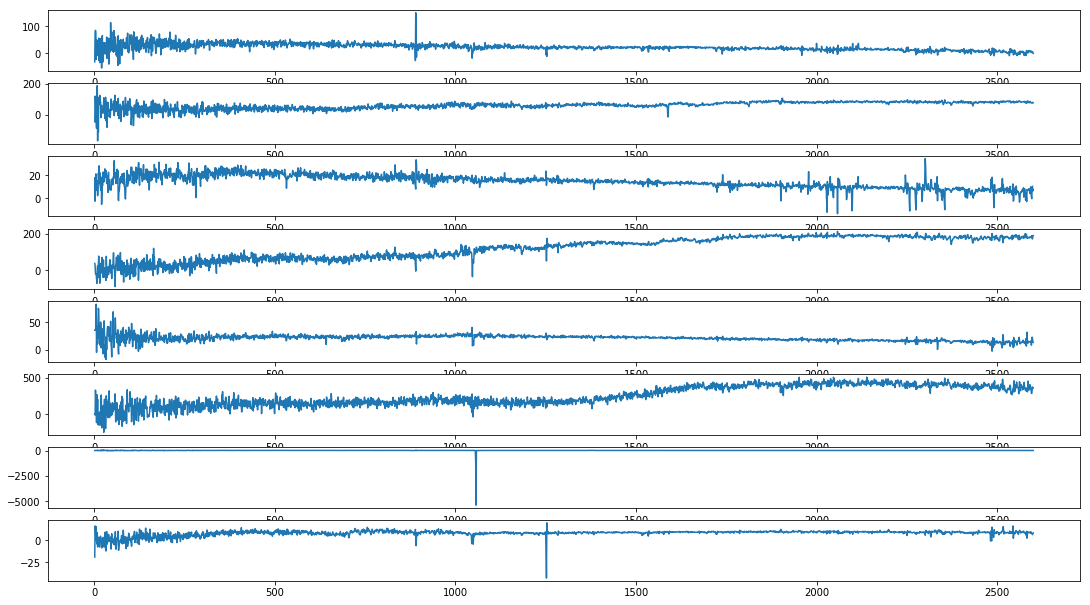

In [70]:
missed_qso = missed_feature[missed_feature.label=='star']
plotSpec(missed_qso.iloc[:,:-2])

In [89]:
k = pd.Series(preds_test)
k.value_counts()

star       2623
unknown     349
galaxy       24
qso           4
dtype: int64

In [ ]:
if validMode:
    clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced',  verbose=1 )
    rs = clf.fit(x, y)
    preds_test = clf.predict(t_x)
    # clf.score(t_x, t_y)
    print('f1: %.2f' % f1_score(t_y, preds_test, average='macro')) 
    print(classification_report(t_y, preds_test, labels=['galaxy', 'qso', 'star', 'unknown']))
    print(confusion_matrix(t_y, preds_test, labels=['galaxy', 'qso', 'star', 'unknown']))

In [ ]:
if validMode:
    rs = clf.fit(x, y)
    scores = cross_val_score(clf, x, y, cv=3, n_jobs=-1, verbose=1, scoring='f1_macro')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#     preds_test = clf.predict(t_x)
    # clf.score(t_x, t_y)
#     print("%0.3f" % f1_score(t_y, preds_test, average='macro'))  

In [ ]:
if validMode:
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()


In [ ]:
if validMode:
    smote = SMOTE()
    parameters = {
        'max_depth':[60, 70, 80],  #70
        'max_features':[0.5,0.6,0.7], #0.6
    #     'min_samples_split':[2, 4, 8, 20], #2
    #     'min_samples_leaf':[1,4,8,20], #1
    #     'min_weight_fraction_leaf':[0,0.05,0.1,0.2], #0
        'max_leaf_nodes':[800, 1000, 1200], #1000
    #      'bootstrap':[True, False], #False
    #     'oob_score':[True, False], #False
    #     'class_weight':[None,'balanced'], #balanced
        'n_estimators':[10, 20], #10
    #     'criterion':['gini','entropy']
    }
    clf = GridSearchCV(RandomForestClassifier(n_jobs=4, max_depth=20), parameters, cv=5,
                           scoring='f1_macro', n_jobs=8, verbose=2)
    clf.fit(x, y)
    print(clf.best_params_)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [16]:
if reFeature:
    testTotal = readTotalFeature('./test_feature_all_', 9, False, partition=40)
    testTotal.to_csv('./test_feature_checkpoint.csv', index=False)
    testTotal.head()
else :
    testTotal = pd.read_csv('./test_feature_checkpoint.csv')

In [18]:
testTotal.head()
total_train_feature.shape

(483851, 321)

In [19]:
clf.fit(total_train_feature.iloc[:,:-1], total_train_feature.iloc[:,-1])



[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  5.1min finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('model', RandomForestClassifier(bootstrap=True, class_weight=...random_state=<mtrand.RandomState object at 0x1a0b83b280>,
            verbose=1, warm_start=False))])

In [20]:
test_x = testTotal.iloc[:,:-1]
pred = clf.predict(test_x)
timestr = time.strftime("%m%d_%H%M")
submit(timestr+'_rf_40.csv',testTotal, pred)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished
/Users/cql/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,pred
0,1342620,star
1,840942,unknown
2,779867,star
3,811734,star
4,714212,star
5,982862,star
6,1315957,star
7,895462,galaxy
8,1239467,star
9,937894,star


In [ ]:
total_train_feature.head()

In [ ]:
total_train_feature[:,:-1]